This entire lecture will be about Gaussians. \
We will be building a Gaussian DataClass in Python. \
A Python dataclass is a decorator simplifies the creation of classes that are primarily used to store data. \
It automatically generates special methods like __init__(), __repr__(), __eq__(), and more, based on class attributes.

The `logpdf` function evaluates `log` of the normal distribution

$$
\log  \mathcal{N} (\vec{x}; \vec{\mu},\Sigma) = - \frac{1}{2}(\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x}-\vec{\mu}) - 
\frac{1}{2} \log(\det{\Sigma}) - \frac{D}{2} \log(2\pi)
$$ 

But, instead of copmuting $\Sigma^{-1}$ explicitly in $\Sigma ^{-1}(\vec{x}-\vec{\mu}) $ we solve for $\vec{z}$ in the linear equation $\Sigma \vec{z} = \vec{x} - \vec{\mu}$ and then plug $z = \Sigma^{-1}(\vec{x}-\vec{\mu})$ into $(\vec{x} - \vec{\mu})^T \vec{z}$

Computing the inverse explicitly is usually frowned upon in numerics. \
Solving the linear equation is much more efficient and stable. 



To compute the square-root of a matrix, use `SVD` \
$ A = UDV^T$ where $D$ is a diagonal matrix \
Then $ A^{1/2} = UD^{1/2}V^T$ where $D^{1/2}$ is just elementwise square-root of the diagonal elements. 

In [2]:
from dataclasses import dataclass
from typing import Self
from jax import numpy as jnp
from jaxtyping import Array,Float
import functools

@dataclass
class Gaussian:
    mu: Float[Array, "D"]
    sigma: Float[Array, "D D"]

    @functools.cached_property
    def cov_svd(self):
        """ compute AA' = Sigma """
        if(jnp.isscalar(self.mu)):
            return jnp.eye(1),jnp.sqrt(self.sigma).reshape(1,1)
        else:
            U,D,V = jnp.linalg.svd(self.sigma, full_matrices=True, hermitian=True)
            return U,jnp.sqrt(D) # RETURN THE SQRT OF DIAGONALIZED-SIGMA

    @functools.cached_property
    def logdet(self):
        """ log-determinant of the covariance matrix eg: for computing the log-pdf """
        _,D = cov_svd
        return 2 * jnp.sum(jnp.log(D))

    @functools.cached_property
    def precision(self):
        """ precision is the inverse of the covariance-matrix """
        """ you probably dont want to call this directly, but rather through prec_mult """
        U,D = self.cov_svd
        return U @ jnp.diag(1/D)**2 @ U.T
        
    def prec_mult(self, x:Float[Array,"D "]) -> Float[Array, "D "]:
        """ precision matrix multiplication """
        """ implements Sigma^{-1} @ x. For numerical-stability we use the Cholesky factorization """
        U,D = self.cov_svd
        return U @ jnp.diag(1/D**2) @ U.T @ x

    @functools.cached_property
    def mp(self):
        """ precision-adjusted-mean """
        return self.prec_mult(self.mu)


    def log_pdf(self, x:Float[Array,"D "]) -> float:
        """log N(x; mu,sigma)"""
        return (
            -0.5 * (x - self.mu) @ jnp.linalg.solve(self.sigma, x - self.mu)
            -0.5 * jnp.linalg.slogdet(self.sigma)[1]
            -0.5 * len(self.mu) * jnp.log(2*jnp.pi)
        )

    def pdf(self,x:Float[Array, "D "]) -> float:
        """N(x; mu,sigma)"""
        return jnp.exp(self.log_pdf(x))

    def cdf(self, x):
        if jnp.isscalar(x):
            return 0.5 * (1 + jax.scipy.special.erf((x-self.mu) / jnp.sqrt(2*self.sigma)))
        else:
            raise NotImplementedError("CDF not implelemented for multivariate gaussians")

    def __mult__(self, other:Self)->Self:
        """ multiplication of two gaussian PDFs """
        sigma = jnp.linalg.inv(self.precision + other.precision)
        mu = sigma @ (self.mp + other.mp)
        return Gaussian(mu = mu, sigma = sigma)

    def __rmatmul__(self, A:Float[Array, "N D"])->Self:
        """ Linear maps of Gaussian RVs are Gaussian RVs """
        return Gaussian(mu = A @ self.mu, sigma = A@self.sigma @A.T)
        

    def condition(self, A:Float[Array, "N D"], y:Float[Array, "N"], 
                 Lambda: Float[Array, "N N"]) -> Self:
        """ Linear conditionals of Gaussian RVs are Gaussian RVs 
        returns p(self | y) = N(y; A @ self, Lambda) * self/p(y)
        where Lambda is noise N(0,lambda)
        """
        Gram = A @ self.sigma @ A.T + Lambda
        L = jax.scipy.linalg.cho_factor(Gram, lower=True)
        mu = self.mu + self.sigma @ A.T @ jax.scipy.linalg.cho_solve(L, y - A@self.mu)
        sigma = self.sigma - self.sigma @ A.T @ jax.scipy.linalg.cho_solve(L, A @ self.sigma)
        return Gaussian(mu=mu, sigma=sigma)
            

## Properties of Gaussians

#### 1. Properties of Gaussians - Products of two gaussians is gaussian
   $ \mathcal{N}(x; \mu_1, \sigma_1) \cdot \mathcal{N}(x; \mu_2, \sigma_2) = \kappa \cdot \mathcal{N}(x;\mu_3,\sigma_3)) $ where \
   $\sigma_3 = (\sigma_1^{-1} + \sigma_2^{-1})^{-1} $ \
   $\mu_3 = \sigma_3 \cdot (\sigma_1^{-1} \cdot \mu_1 + \sigma_2^{-1} \cdot \mu_2)$ \
   $ \kappa = \mathcal{N}(x; \mu_2, \sigma_1 + \sigma_2) \mid _{x=\mu_1}  = \mathcal{N}(x; \mu_1, \sigma_1 + \sigma_2) \mid _{x=\mu_2} $



#### 2. Properties of Gaussians - Linear Project of a Gaussian produces Gaussian
$ p(\vec{x}) = \mathcal{N}(\vec{x}; \vec{\mu},\Sigma)$ \
$ p(A\vec{x}) = \mathcal{N}(A\vec{x}; A\vec{\mu}, A \Sigma  A^T)$



#### 3. Properties of Gaussians - Shifting a gaussian produces gaussian
   $ p(x) = \mathcal{N}(x; \mu, \Sigma)$ \
   $p(z = x + b) = \mathcal{N}(z; \mu+b, \Sigma)$

<i> A quick note on the difference between <b>Marginal</b> and <b>Conditional</b> </i> \
Marginal distribution represents the probability distribution of a single variable, ignoring the influence of other variables i.e we integrate over all the other random-variables. How much of a distribution's variance is explainable through one of the components? Imagine a 2D distribution, $P(t,h) = \mathcal{N}(t,h;\vec{\mu} \Sigma)$ the probability of rain as a function of temperature and humidity. If we ignore humidity, then $P(t) = \int P(t,h)dh $ is also Gaussian. Graphically, $P(t_i) = \Sigma_{j}P(t_i,h_j)$ and we compute this for each $t_i$\
This is unlike conditionals where we are interested in a particular value of humidity $P(t|h=80\%) = P(t,h)/P(h=80\%)$. Graphically, this is a slice of the 2D Gaussian. 


#### 4. Property: Marginals of a Gaussian are gaussian
   $ p(\vec{z}) = \mathcal{N}(\vec{z}; \vec{\mu}, \Sigma)$ where 
   $\vec{z} = \begin{bmatrix} x\\ y \end{bmatrix} $ and 
   $\Sigma = \begin{bmatrix} \Sigma_{xx} & \Sigma_{xy} \\ \Sigma_{yx} & \Sigma_{yy} \end{bmatrix}$ 

   Linear-Transforming \
   $ p(A\vec{z}) = \mathcal{N}(A\vec{z}; A\vec{\mu}, A\Sigma A^T)$ 
   
   Choose $A = [1,0]$ \
   $ p(A\vec{z}) = p(x) = \mathcal{N}(x;\mu_x,\Sigma_{xx})$ 

   i.e the <b>marginal</b> $P(x)$ is also Gaussian. 
   
   So, we could use linear-projections for computing integrals such as \
   $ p(x) = \int{p(\vec{z}) dy} = \int{p(y\mid x)p(x)dy}$


#### 5. Property: <i>Linear</i> Conditionals of a Gaussian are gaussian
   $ p(\vec{z}) = \mathcal{N}(\vec{z}; \vec{\mu}, \Sigma)$ where 
   $\vec{z} = \begin{bmatrix} x\\ y \end{bmatrix} $ and 
   $\Sigma = \begin{bmatrix} \Sigma_{xx} & \Sigma_{xy} \\ \Sigma_{yx} & \Sigma_{yy} \end{bmatrix}$ 

Given an observation $\vec{w} = A \vec{z} + \vec{\epsilon} $ where $A$ is linear, and $ \vec{\epsilon} = \mathcal{N}(\vec{0},\Lambda) $ is the measurement noise \
$ p(\vec{z} | \vec{w}) = \mathcal{N}(\vec{z}; \mu_{cond},\Sigma_{cond}) $ \
$\vec{\mu}_{cond} = \vec{\mu} + \Sigma A^T (A\Sigma A^T + \Lambda)^{-1}(\vec{w} - A \vec{\mu}) $ \
$\Sigma_{cond} = \Sigma - \Sigma A^T (A\Sigma A^T + \Lambda)^{-1}A \Sigma $

in the `condition` function defined in `class Gaussian` \
`y` is the observation \
`Lambda` is the covariance-matrix of measurement noise. \
`Gram` $ = A \Sigma A^T + \Lambda$ is the covariance of the observation `y` \
`L` is such that `Gram` = $LL^T$ is the Cholesky factorization of the `Gram` matrix. Much more efficient than computing the inverses. 

$p(\vec{w} \mid \vec{z}) = \mathcal{N}(\vec{w}; A\vec{z} + \vec{b}, \Lambda)$ \
$p(\vec{w}) = \mathcal{N}(\vec{w}; A\vec{\mu}+\vec{b},\Lambda + A \Sigma A^T)$ \
$p(\vec{z}\mid \vec{w}) = \mathcal{N}(\vec{z};\vec{\mu}_{cond},\Sigma_{cond})$ \
depending on the type of problem you're solving, there are 2 ways to compute $\vec{\mu}_{cond}, \Sigma_{cond}$
1. $\vec{\mu}_{cond} = \vec{\mu} + \texttt{Gain * Residual} = \vec{\mu}  + \Sigma A^T (A \Sigma A^T + \Lambda)^{-1}(\vec{w} - (A\vec{\mu} + \vec{b})) $ \
   $\Sigma_{cond} = \Sigma - \Sigma A^T (A \Sigma A^T + \Lambda)^{-1}A\Sigma$ \
   `residual` i.e difference between true-measurement $\vec{w}$ and model-measurement $A\vec{\mu} + \vec{b}$ \
   `Gain` i.e how sensitive is $\Delta \mu$ to the `residual`. \
    $(A\Sigma A^T + \Lambda)$ is the `Gram Matrix`.
2. $\vec{\mu}_{cond} = (\Sigma^{-1} + A^T\Lambda^{-1}A)^{-1}\lbrace A^T\Lambda^{-1}(\vec{w} - \vec{b}) + \Sigma^{-1}\vec{\mu}\rbrace$ \
   $\Sigma_{cond} = (\Sigma^{-1} + A^T \Lambda^{-1}A)^{-1}$ \
   $\Sigma ^{-1} + A^{T}\Lambda A^{-1}$ is the `Precision Matrix`. 

The first one is called the `Data Space` because `Gain` has size `N x N` where `N` is size of $\vec{w}$ i.e number of data points \
The second is called `Weight Space` because `Precision Matrix` has the size `N x N` where `N` is size of $\vec{z}$ i.e the number of parameters. \
Depending on whether i have more data or more parameters, one of the two will be the cheaper computation


## Plots to demonstrate the above properties

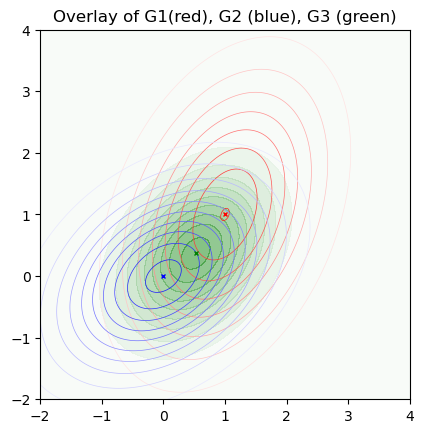

In [4]:
# Plot -  Products of 2 Gaussians is also Gaussian
mu1 = jnp.array([1.0,1.0])
sigma1 = jnp.array([[1, 0.5],[0.5,2]])
G1 = Gaussian(mu1,sigma1)

mu2 = jnp.array([0.0,0.0])
sigma2 = jnp.array([[1.2, 0.5],[0.3,1]])
G2 = Gaussian(mu2,sigma2)

G3 = G1.__mult__(G2)
mu3 = G3.mu
sigma3 = G3.sigma

from jax import vmap 
from matplotlib import pyplot as plt
from matplotlib import colors
cmp_wd1 = colors.LinearSegmentedColormap.from_list("wd",['w','r'],N=1024)
cmp_wd2 = colors.LinearSegmentedColormap.from_list("wd",['w','b'],N=1024)
cmp_wd3 = colors.LinearSegmentedColormap.from_list("wd",['w','g'],N=1024)
X,Y = jnp.mgrid[-2:4:200j, -2:4:200j]
nplot = X.shape[0]
XY = jnp.dstack((X,Y)).reshape(nplot**2,2)
Z1 = vmap(G1.pdf)(XY).reshape(nplot,nplot)
Z2 = vmap(G2.pdf)(XY).reshape(nplot,nplot)
Z3 = vmap(G3.pdf)(XY).reshape(nplot,nplot)

fig,ax = plt.subplots()

# plot contours
ax.contour(X,Y,Z1, levels=10, cmap=cmp_wd1, linewidths=0.5)
ax.contour(X,Y,Z2, levels=10, cmap=cmp_wd2, linewidths=0.5)
ax.contourf(X,Y,Z3, levels=10, cmap=cmp_wd3, alpha=0.5)

# plot means
ax.plot(mu1[0], mu1[1], 'x', color='r', markersize=3)
ax.plot(mu2[0], mu2[1], 'x', color='b', markersize=3)
ax.plot(mu3[0], mu3[1], 'x', color='g', markersize=3)

ax.set_title("Overlay of G1(red), G2 (blue), G3 (green)")
ax.set_aspect('equal')
plt.show()


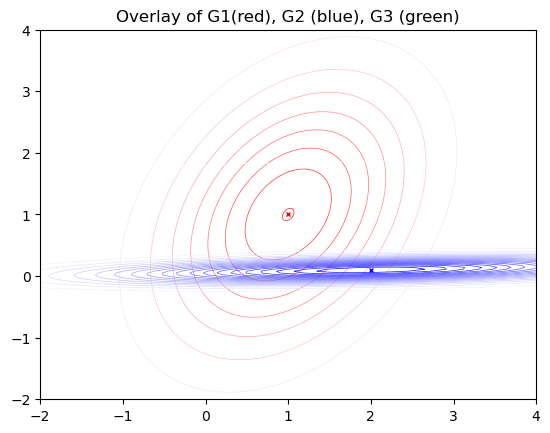

In [5]:
# Plot - Linear Projection of Gaussian is Gaussian
mu1 = jnp.array([1.0,1.0])
sigma1 = jnp.array([[1, 0.5],[0.5,2]])
G1 = Gaussian(mu1,sigma1)

A = jnp.array([[2,0.0],[0,0.1]]) 
G2 = G1.__rmatmul__(A)
(mu2,sigma2) = (G2.mu,G2.sigma)

from jax import vmap 
from matplotlib import pyplot as plt
from matplotlib import colors
cmp_wd1 = colors.LinearSegmentedColormap.from_list("wd",['w','r'],N=1024)
cmp_wd2 = colors.LinearSegmentedColormap.from_list("wd",['w','b'],N=1024)
X,Y = jnp.mgrid[-2:4:200j, -2:4:200j]
nplot = X.shape[0]
XY = jnp.dstack((X,Y)).reshape(nplot**2,2)
Z1 = vmap(G1.pdf)(XY).reshape(nplot,nplot)
Z2 = vmap(G2.pdf)(XY).reshape(nplot,nplot)

fig,ax = plt.subplots()

# plot contours
ax.contour(X,Y,Z1, levels=10, cmap=cmp_wd1, linewidths=0.5)
ax.contour(X,Y,Z2, levels=20, cmap=cmp_wd2, linewidths=0.5)

# plot means
ax.plot(mu1[0], mu1[1], 'x', color='r', markersize=3)
ax.plot(mu2[0], mu2[1], 'x', color='b', markersize=3)

ax.set_title("Overlay of G1(red), G2 (blue), G3 (green)")
# ax.set_aspect('equal')
plt.show()


### Example from DJC MacKay
#### temperature inside building is modeled as linear-transform of temperature outside. 
$x_2$ is outside temperature \
$x_1$ is building-1 temperature \
$x_3$ is building-2 temperature 

$x_2 = \nu_2$ (shifted so that outside mean-temp is 0)\
$x_1 = w_1x_2 + \nu_1$ \
$x_3 = w_3x_2 + \nu_3$ 

$\nu_1, \nu_2\ \nu_3$ are measurement noise modelled as a Gaussian $\mathcal{N}(\nu_i, \mu_i, \sigma_i^2)$

So, find $p(x_i)$ given $p(\nu_i)$ and $ \begin{bmatrix} x_1 \\ x_2 \\ x3 \end{bmatrix} = \begin{bmatrix} 1 & w_1 & 0 \\ 0 & 1 & 0 \\ 0 & w_3 & 1 \end{bmatrix} \cdot \begin{bmatrix} \nu_1 \\ \nu_2 \\ \nu_3 \end{bmatrix} $

$p(\vec{x} = A\vec{\nu}) = \mathcal{N}(\vec{x};\vec{\mu}_{new},\Sigma_{new})$ where $\vec{\mu}_{new} = A\vec{\mu}$ and $\Sigma_{new} = A \Sigma A^T$\
This gives the individual probability distribution $p(\vec{x}) = \mathcal{N}(\vec{x};A\vec{\mu}, A\Sigma A^T)$ where 
$A \Sigma A^T = 
\begin{bmatrix} 
w_1 \sigma_2^2 + \sigma_1^2 & w_1\sigma_2^2 & w_1w_3\sigma_2^2
\\ 
\_ & \sigma_2^2 & w_3\sigma_2^2 
\\ 
\_ & \_ & w_3^2\sigma_2^2 + \sigma_3^2
\end{bmatrix} $

The $w_1w_3\sigma_2^2$ term seems to suggest that $x_1$ and $x_3$ are correlated but that's because they are correlated through $x_2$. 

$x_1$ and $x_3$ are <i> marginally dependant </i> but <i>conditionally independant</i> i.e if we fix an $x_2$ then they will become independant. 

To see that they are conditionally independant, compute the joint distribution $p(x_1,x_2,x_3) = p(x_2)p(x1 \mid x_2) p(x_3 \mid x_2)$ \
assume $\vec{\mu} = 0$ i.e mean of measurement error is 0 \
$p(x_2) = \exp \left[ -\frac{1}{2}\frac{x_2^2}{\sigma_2^2} \right] $ \
$p(x_1 \mid x_2) = \exp \left[ -\frac{1}{2} \frac{(x_1 - w_1x_2)^2}{\sigma_1^2}\right]$ \
$p(x_3 \mid x_2) = \exp \left[ -\frac{1}{2} \frac{(x_3 - w_3x_2)^2}{\sigma_3^2}\right]$ 

$p(x_1,x_2,x_3) = \exp \left[ -\frac{1}{2} \vec{x} \cdot \Sigma_{joint} \cdot \vec{x}^T \right]$ where $\Sigma_{joint} = 
\begin{bmatrix} 
\frac{1}{\sigma_1^2} & -\frac{w_1}{\sigma_1^2} & 0 
\\ 
-\frac{w_1}{\sigma_1^2} & (\frac{1}{\sigma_2^2} + \frac{w_1^2}{\sigma_1^2} + \frac{w_3^2}{\sigma_3^2}) & -\frac{w_3}{\sigma_3^2}
\\ 
0 & -\frac{w_3}{\sigma_3^2} & \frac{1}{\sigma_3^2} 
\end{bmatrix} $

#### Measurement _Likelihoods_ $p(y \mid x)$ for Gaussian distributions

Given a measurement $y = ax  + b  + \epsilon$ where $\epsilon \sim \mathcal{N}(0,\sigma^2)$ is the measurement noise, the _likelihood_ $P(y \mid x)$ of this measurement being accurate is also a gaussian with __variance__ $\sigma^2$ except the __mean__ is shifted to $ax + b$ because that's the most likely outcome. 

$p(y \mid x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \lbrack \frac{-(y - ax - b)^2}{2\sigma^2} \rbrack \sim \mathcal{N}(y; ax+b, \sigma^2)$